In [11]:
import os
import shutil
import random
from collections import defaultdict, Counter
import cv2
import numpy as np
import shutil 
import matplotlib.pyplot as plt

In [12]:
# Common parameters
IMAGE_SIZE = 448
TARGET_COUNT = 1500
DATA_PATH = './data/pascal_voc_training_data.txt'
IMAGE_DIR = './data/VOCdevkit_train/VOC2007/JPEGImages/'
MOS_DATA_PATH = './data/mos_training_data.txt'
MOS_IMAGE_DIR = './data/mos_JPEG/'

In [13]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [ ]:
def read_annotations(file_path):
    annotations = defaultdict(list)
    with open(file_path, 'r') as f:
        for line_number, line in enumerate(f, start=1):
            parts = line.strip().split()
            if len(parts) < 6 or (len(parts) - 1) % 5 != 0:
                print(f"Warning: Line {line_number} in {file_path} does not match the expected format. Skipping this line.")
                continue
            img_name = parts[0]
            for i in range(1, len(parts), 5):
                x_min, y_min, x_max, y_max, class_id = map(int, parts[i:i+5])
                annotations[img_name].append((x_min, y_min, x_max, y_max, class_id))
    return annotations

def count_classes(annotations):
    class_counter = Counter([bbox[4] for boxes in annotations.values() for bbox in boxes])
    return class_counter

def init_classes(annotations):
    class_counter = Counter([bbox[4] for boxes in annotations.values() for bbox in boxes])
    for cls in class_counter:
        class_counter[cls] = 0
    return class_counter

def load_image_and_labels(img_folder, img_name, bboxes):
    # 加載原始圖片
    img = cv2.imread(os.path.join(img_folder, img_name))
    original_height, original_width = img.shape[:2]

    # 調整圖片大小到 IMAGE_SIZE x IMAGE_SIZE
    img = cv2.resize(img, (IMAGE_SIZE //2, IMAGE_SIZE //2 ))
    resized_height, resized_width = IMAGE_SIZE //2 , IMAGE_SIZE //2

    # 計算寬高縮放比例
    width_scale = resized_width / original_width
    height_scale = resized_height / original_height

    # 調整 bounding box
    adjusted_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max, class_id = bbox
        x_min = int(x_min * width_scale)
        y_min = int(y_min * height_scale)
        x_max = int(x_max * width_scale)
        y_max = int(y_max * height_scale)
        adjusted_bboxes.append((x_min, y_min, x_max, y_max, class_id))
    
    return img, adjusted_bboxes

def mosaic_augmentation(images_and_labels , min_distance = 10 , min_area = 500):
    h, w, _ = images_and_labels[0][0].shape
    mosaic_image = np.zeros((h * 2, w * 2, 3), dtype=np.uint8)
    mosaic_labels = []
    positions = [(0, 0), (0, w), (h, 0), (h, w)]
    scale_factor = 1  # 固定縮放比例為 1

    for i, (img, labels) in enumerate(images_and_labels):
        # 固定縮放每張圖片到 Mosaic 區域大小
        img_resized = cv2.resize(img, (int(w * scale_factor), int(h * scale_factor)))

        offset_x, offset_y = positions[i]
        mosaic_image[offset_y:offset_y + img_resized.shape[0], offset_x:offset_x + img_resized.shape[1]] = img_resized

        # 調整 bounding box 並添加到 Mosaic 標註
        for label in labels:
            x_min, y_min, x_max, y_max , cls= label
            x_min = int(x_min * scale_factor + offset_x)
            y_min = int(y_min * scale_factor + offset_y)
            x_max = int(x_max * scale_factor + offset_x)
            y_max = int(y_max * scale_factor + offset_y)
            width = x_max - x_min
            height = y_max - y_min
            notboundary =  (width * height >= min_area // 4 and x_min > min_distance + offset_x and y_min > min_distance + offset_y and x_max < offset_x + IMAGE_SIZE // 2 - min_distance and y_max < offset_y + IMAGE_SIZE // 2 - min_distance )
            isboundary = (width * height >= min_area)
            if isboundary or notboundary :
                mosaic_labels.append(( x_min, y_min, x_max, y_max , cls))

    return mosaic_image, mosaic_labels

def generate_mosaic_data(annotations, img_folder, target_folder, target_txt_path, target_count):
    if os.path.exists(target_folder):
        shutil.rmtree(target_folder)
        
    os.makedirs(target_folder)
    class_counts = init_classes(annotations)

    img_counter = 1  # 初始化圖片計數器
    with open(target_txt_path, "w") as target_file:
        while any(count < target_count for count in class_counts.values()):
            updated = False
            
            # 篩選出至少包含一個未滿 `target_count` 類別的圖片且具有 bounding box
            under_target_images = [
                img_name for img_name, bboxes in annotations.items()
                if bboxes and all(class_counts[bbox[4]] < target_count for bbox in bboxes)
            ]

            # 如果沒有足夠的圖片來生成 Mosaic，則退出
            if len(under_target_images) < 6 or min(class_counts.values()) > target_count * 0.5:
                print("Not enough images with classes below target count. Stopping.")
                break

            # 隨機從篩選出的圖片中選擇 4 張進行 Mosaic augmentation
            chosen_imgs = random.sample(under_target_images, 4)
            images_and_labels = [(load_image_and_labels(img_folder, img, annotations[img])) for img in chosen_imgs]
            mosaic_image, mosaic_labels = mosaic_augmentation(images_and_labels)

            # 生成符合要求的檔名，例如 "000001.jpg"
            target_img_name = f"{img_counter:06}_mos.jpg"
            target_img_path = os.path.join(target_folder, target_img_name)
            cv2.imwrite(target_img_path, mosaic_image)
            img_counter += 1  # 增加計數器

            line = [target_img_name]
            for x_min, y_min, x_max, y_max ,cls in mosaic_labels:
                line.extend([str(x_min), str(y_min), str(x_max), str(y_max), str(cls)])
                class_counts[cls] += 1
                updated = True

            target_file.write(" ".join(line) + "\n")
                    
            # 如果這一輪沒有更新，則停止增強
            if not updated:
                print("No further augmentations could be made. Stopping.")
                break

            # 檢查是否所有類別都達到目標數量
            if all(count >= target_count for count in class_counts.values()):
                print("All classes have reached the target count.")
                return

In [15]:
annotations = read_annotations(DATA_PATH)
generate_mosaic_data(annotations, IMAGE_DIR, MOS_IMAGE_DIR, MOS_DATA_PATH, TARGET_COUNT)

Not enough images with classes below target count. Stopping.


In [16]:
annotations = read_annotations(MOS_DATA_PATH)
class_counts = count_classes(annotations)
print(class_counts)

Counter({4: 1527, 10: 1504, 19: 1503, 6: 1503, 17: 1502, 8: 1501, 5: 1501, 11: 1501, 9: 1501, 0: 1501, 12: 1501, 16: 1501, 18: 1500, 2: 1500, 15: 1500, 7: 1500, 3: 1500, 13: 1500, 1: 1500})


In [17]:
def show_visualization_multiple_boxes(image_path, boxes, classes_name):
    """
    显示图片并在图片上画出多个边界框和物件类别。
    
    :param image_path: 图片的路径
    :param boxes: 包含每个物件的 bounding box 信息，格式为 [(xmin, ymin, xmax, ymax, class_num), ...]
    :param classes_name: 类别名称列表，用于将类别编号映射为名称
    """
    # 读取图片
    np_img = cv2.imread(image_path)
    if np_img is None:
        print("Error: Unable to load image at path:", image_path)
        return
    
    # 调整图片大小并转换颜色
    IMAGE_SIZE = 448  # 设置为所需的图像大小
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    resized_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)

    # 绘制每个边界框
    for (xmin, ymin, xmax, ymax, class_num) in boxes:
        # 获取类别名称
        class_name = classes_name[class_num]

        # 绘制边界框
        cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 2)
        
        # 绘制类别标签
        cv2.putText(resized_img, class_name, (int(xmin), int(ymin) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    # 显示图片
    print(resized_img.shape)
    filename = os.path.basename(image_path)
    print(filename)
    plt.imshow(resized_img)
    plt.axis("off")
    plt.show()

def read_annotations(data_path):
    annotations = {}
    with open(data_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        filename = parts[0]
        bbox_data = parts[1:]
        boxes = []
        for i in range(0, len(bbox_data), 5):
            xmin = float(bbox_data[i])
            ymin = float(bbox_data[i + 1])
            xmax = float(bbox_data[i + 2])
            ymax = float(bbox_data[i + 3])
            class_num = int(bbox_data[i + 4])
            boxes.append((xmin, ymin, xmax, ymax, class_num))
        annotations[filename] = boxes
    return annotations

# 主程序：随机选择图片进行可视化
def visualize_random_images(image_folder, data_path, num_images):
    annotations = read_annotations(data_path)
    image_names = list(annotations.keys())
    random.shuffle(image_names)
    selected_images = image_names[:num_images]
    for image_name in selected_images:
        image_path = os.path.join(image_folder, image_name)
        boxes = annotations[image_name]
        print(image_name)
        show_visualization_multiple_boxes(image_path, boxes, classes_name)



In [18]:
def filter_bounding_boxes(bboxes , min_distance = 20):
    """
    過濾掉寬或高小於 min_size 的 bounding box
    bboxes: 每個 bounding box 的格式 [x_min, y_min, x_max, y_max, class_id]
    min_size: 最小邊長閾值
    """
    filtered_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max, cls_id = bbox
        width = x_max - x_min
        height = y_max - y_min
        if width * height >= 2000 or( x_min > min_distance and y_min > min_distance and x_max < IMAGE_SIZE * 2 - min_distance and y_max < IMAGE_SIZE * 2 - min_distance and width * height >= 500):
            filtered_bboxes.append(bbox)
    return filtered_bboxes


(448, 448, 3)
001411_mos.jpg


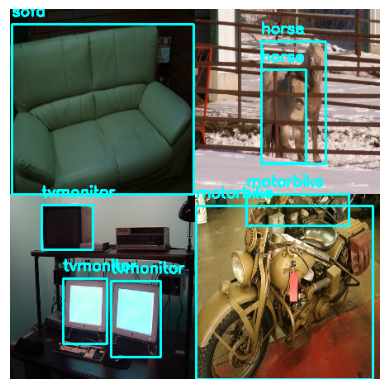

(448, 448, 3)
001411_mos.jpg


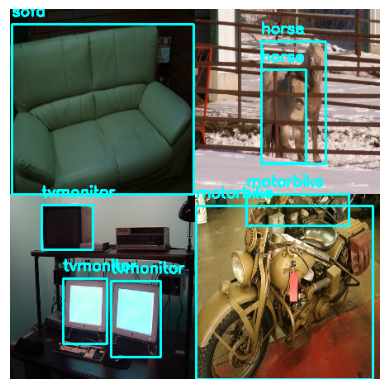

In [ ]:
annotations = read_annotations(MOS_DATA_PATH)
show_visualization_multiple_boxes('./data/mos_JPEG/004310_mos.jpg', annotations['004310_mos.jpg'], classes_name)

002667_mos.jpg
(448, 448, 3)
002667_mos.jpg


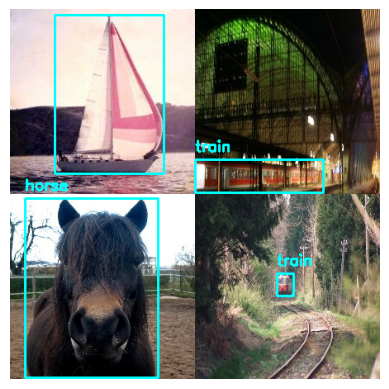

000504_mos.jpg
(448, 448, 3)
000504_mos.jpg


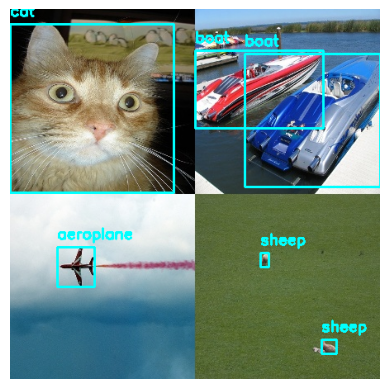

000168_mos.jpg
(448, 448, 3)
000168_mos.jpg


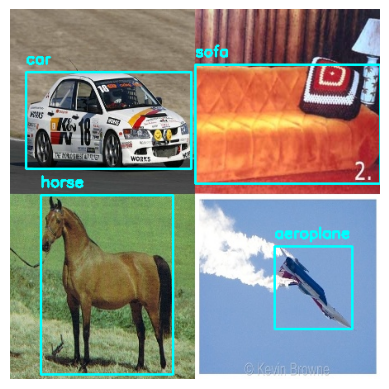

003377_mos.jpg
(448, 448, 3)
003377_mos.jpg


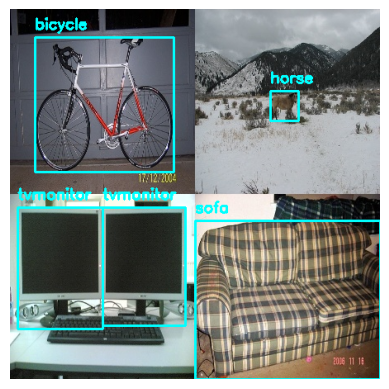

001782_mos.jpg
(448, 448, 3)
001782_mos.jpg


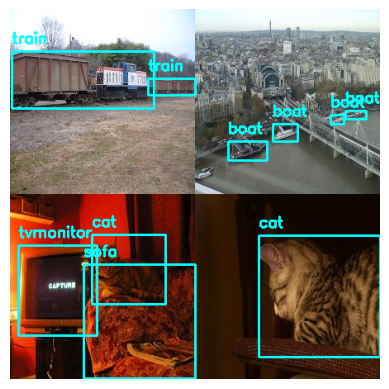

003639_mos.jpg
(448, 448, 3)
003639_mos.jpg


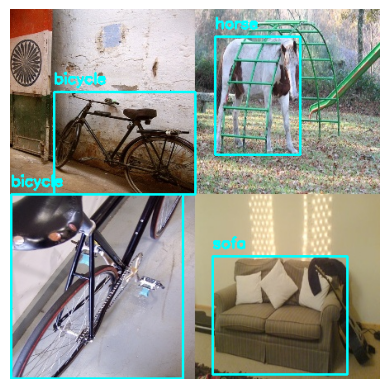

003835_mos.jpg
(448, 448, 3)
003835_mos.jpg


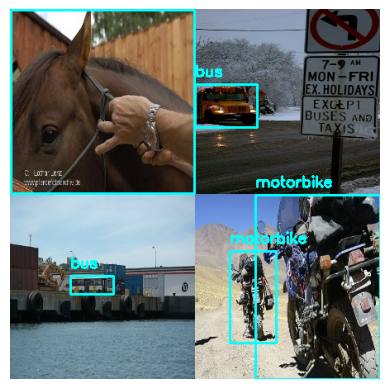

002965_mos.jpg
(448, 448, 3)
002965_mos.jpg


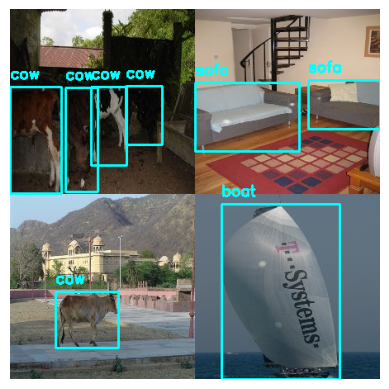

001328_mos.jpg
(448, 448, 3)
001328_mos.jpg


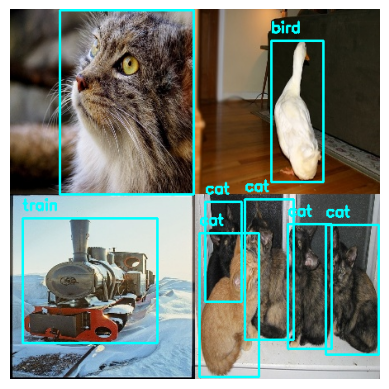

001277_mos.jpg
(448, 448, 3)
001277_mos.jpg


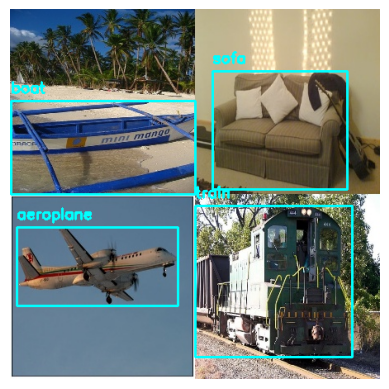

In [24]:
visualize_random_images(MOS_IMAGE_DIR, MOS_DATA_PATH, num_images = 10)